# Code for Visualizing Rolling Correlations as Graph Networks

Idea is to visualize dynamically the correlations between various asset classes' closing price throughout time. 
Output will be rendered as a dashboard using python package Dash. 



LEFT TO DO : 
1) Solve the issue with nodes_with_no_edges 
2) Check different nx layouts
3) Make graph more visually appealing : edge colors (shades or green and red for diff values of corr_threshold) 
3) Make the graph dynamic with Dash package : date_chosen, span, corr_threshold, play_with_nodes
5) Even further : make it live to today's date 
6) Even further : add_node_functionality --> retrieve data directly from YahooFinance!

In [2]:
#Import requirements

import subprocess
import sys

import warnings
warnings.filterwarnings("ignore")

# def install_package(package):
#     subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--upgrade", "--no-cache-dir"])

# packages_to_install = ['yfinance', 'yahoo_fin', 'networkx', 'dash', 'dash-bootstrap-components', 'plotly']
# for package in packages_to_install: 
#     install_package(package)
# packname = ''
# install_package(packname)

import re
import time
import webbrowser
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import networkx as nx
from datetime import datetime
from functools import reduce
import matplotlib.pyplot as plt
import yahoo_fin.stock_info as si

import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objs as go



# Data Wrangling

In [356]:
main_file = pd.read_csv('merged_df.csv')

main_file.head(10)

,Date,AAPL: Close,AAPL: Norm_PV,AAPL: Log-Returns,META: Close,META: Norm_PV,META: Log-Returns,V: Close,V: Norm_PV,V: Log-Returns,...,LQD: Log-Returns,BTC-USD: Close,BTC-USD: Norm_PV,BTC-USD: Log-Returns,ETH-USD: Close,ETH-USD: Norm_PV,ETH-USD: Log-Returns,XRP-USD: Close,XRP-USD: Norm_PV,XRP-USD: Log-Returns
0,2017-11-09,43.970001,0.018391,-0.204476,179.300003,0.041481,-0.144900,112.139999,0.025819,-0.293845,...,-0.265032,7143.580078,0.402166,-4.329979,320.884003,0.010413,NaN,0.217488,0.000006,NaN
1,2017-11-10,43.667500,0.015578,-0.690350,178.460007,0.036244,-0.469587,111.879997,0.024952,-0.232124,...,-0.573880,6618.140137,0.601477,-7.639968,299.252991,0.009633,-6.979036,0.206483,0.000005,-5.192559
2,2017-11-13,43.492500,0.010478,-0.401559,178.770004,0.031234,0.173556,111.400002,0.042517,-0.429950,...,0.016684,6559.490234,0.716904,9.750994,316.716003,0.011989,2.820448,0.203442,0.000005,3.045793
3,2017-11-14,42.834999,0.015060,-1.523301,178.070007,0.031316,-0.392331,111.980003,0.033781,0.519297,...,0.025015,6635.750000,0.370202,1.155881,337.631012,0.013121,6.394813,0.209825,0.000005,3.089283
4,2017-11-15,42.270000,0.017485,-1.327788,177.949997,0.033475,-0.067418,110.250000,0.040377,-1.556980,...,0.424307,7315.540039,0.536263,9.752916,333.356995,0.008752,-1.273965,0.212956,0.000004,1.481173
5,2017-11-16,42.775002,0.014344,1.187623,179.589996,0.051423,0.917386,111.019997,0.033347,0.695982,...,-0.116298,7871.689941,0.703805,7.327191,330.924011,0.009585,-0.732520,0.227107,0.000043,6.433573
6,2017-11-17,42.537498,0.013216,-0.556785,179.000000,0.042750,-0.329065,109.820000,0.051404,-1.086768,...,0.124602,7708.990234,0.625745,-2.088556,332.394012,0.007508,0.443227,0.226581,0.000017,-0.231876
7,2017-11-20,42.494999,0.009804,-0.099961,178.740005,0.032964,-0.145354,109.949997,0.040140,0.118303,...,0.000000,8200.639648,0.499196,2.021971,366.730011,0.010752,3.423924,0.238759,0.000009,3.296771
8,2017-11-21,43.285000,0.015432,1.841975,181.860001,0.048391,1.730490,111.449997,0.038221,1.355034,...,0.331512,8071.259766,0.602468,-1.590258,360.401001,0.012438,-1.740861,0.233271,0.000009,-2.325378
9,2017-11-22,43.740002,0.015879,1.045690,180.869995,0.034431,-0.545865,110.820000,0.023943,-0.566877,...,0.388127,8253.549805,0.523312,2.233381,380.652008,0.011075,5.466829,0.238859,0.000007,2.367253


In [357]:
# new_df = main_file[['Date','AAPL: Close', 'META: Close']]
# new_df.set_index('Date', inplace=True)
# pd.to_datetime(new_df.index, format='%Y-%m-%d')

main_file['Date'] #date is not an index of main_file. No worries, we need the column for indexing main_df. 

0       2017-11-09
1       2017-11-10
2       2017-11-13
3       2017-11-14
4       2017-11-15
           ...    
1556    2024-02-08
1557    2024-02-09
1558    2024-02-12
1559    2024-02-13
1560    2024-02-14
Name: Date, Length: 1561, dtype: object

In [358]:
#Some text manipulation 
pattern = r"^(.*?): Close$"

# List to hold extracted ticker names
ticker_names = []
column_names = main_file.columns

#Matching the elements of column_names with pattern
for col in column_names:
    match = re.match(pattern, col)
    if match:
        ticker_names.append(match.group(1))  # group(1) refers to the first captured group

#Creating a list with target columns from main_file : "ticker_name: Close"
target_col_names = []
for ticker in ticker_names: 
    col_name = str(ticker + ': Close')
    target_col_names.append(col_name)

main_df = main_file[target_col_names].round(2)

#Creating new column names
# new_column_names = ['AAPL', 'MC.PA', 'JPM', 'NVDA', '^SPX', 'IAU', 'CL=F', 'LQD', 'XRP-USD',
#        'NVDA', 'LLY', 'TSLA', '^SPX','^DJI', '^RUT', 'IAU', 'CPER', 'GSG', 'CL=F', 'TLT', 
#                     'JNK', 'LQD', 'BTC-USD', 'ETH-USD', 'XRP-USD']

#Renaming columns
new_column_names = ['AAPL', 'META', 'V', 'MC.PA', 'NFLX', 'NKE', 'JPM', 'BAC', 'C',
                    'NVDA', 'LLY', 'TSLA', '^SPX', '^DJI', '^RUT', 'IAU', 'CPER',
                    'GSG', 'CL=F', 'TLT', 'JNK', 'LQD', 'BTC-USD', 'ETH-USD', 'XRP-USD']

#Setting main_file['Date'] as index of main_df    
main_df['Date'] = main_file['Date']
main_df.set_index(main_df['Date'], inplace = True)
pd.to_datetime(main_df.index, format='%Y-%m-%d')
main_df.drop('Date', axis=1, inplace=True)

# main_df.head()    #now we have in our main df columns of closing prices for each of our tickers. 
main_df.columns = new_column_names
main_df


,AAPL,META,V,MC.PA,NFLX,NKE,JPM,BAC,C,NVDA,...,IAU,CPER,GSG,CL=F,TLT,JNK,LQD,BTC-USD,ETH-USD,XRP-USD
Date,,,,,,,,,,,,,,,,,,,,,
2017-11-09,43.97,179.30,112.14,249.90,193.90,56.13,97.63,26.49,72.43,51.33,...,24.70,19.89,15.90,57.17,126.00,109.53,120.58,7143.58,320.88,0.22
2017-11-10,43.67,178.46,111.88,248.50,192.02,56.09,97.51,26.51,72.25,54.03,...,24.52,19.75,15.86,56.74,124.10,110.04,119.89,6618.14,299.25,0.21
2017-11-13,43.49,178.77,111.40,245.95,195.08,55.91,97.86,26.40,71.99,53.16,...,24.56,20.09,15.80,56.76,124.36,109.92,119.91,6559.49,316.72,0.20
2017-11-14,42.83,178.07,111.98,245.95,195.71,55.98,97.27,26.24,71.53,53.54,...,24.62,19.64,15.55,55.70,125.20,109.50,119.94,6635.75,337.63,0.21
2017-11-15,42.27,177.95,110.25,244.80,192.12,56.63,98.19,26.79,71.73,52.49,...,24.56,19.65,15.55,55.33,126.56,109.41,120.45,7315.54,333.36,0.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-08,188.32,470.00,275.78,804.50,558.53,103.77,174.80,33.12,54.29,696.41,...,38.45,23.10,21.03,76.22,94.04,94.54,108.30,45301.57,2419.91,0.51
2024-02-09,188.85,468.11,276.43,807.50,561.32,104.50,175.01,33.07,53.99,721.33,...,38.32,22.95,21.07,76.84,93.85,94.75,108.16,47147.20,2487.52,0.53
2024-02-12,187.15,468.90,275.07,821.90,557.85,107.18,175.79,33.62,53.92,722.48,...,38.23,23.17,21.11,76.92,93.96,94.53,108.17,49958.22,2658.12,0.53


In [359]:
# #To take a further step from previous code block : 
# #Automating pattern detection with a list.

# # List of terms you want to check in your pattern
# lst = ['Close', 'Norm_PV', 'Log-Returns']

# # Dictionary to hold extracted ticker names for each term
# ticker_names = {term: [] for term in lst}

# for term in lst:
#     # Dynamically create the pattern with the current term
#     pattern = r"^(.*?): " + term + r"$"
    
#     for col in column_names:
#         match = re.match(pattern, col)
#         if match:
#             # Add the extracted ticker name to the corresponding list
#             ticker_names[term].append(match.group(1))

# print(ticker_names)

main_df.columns

Index(['AAPL', 'META', 'V', 'MC.PA', 'NFLX', 'NKE', 'JPM', 'BAC', 'C', 'NVDA',
       'LLY', 'TSLA', '^SPX', '^DJI', '^RUT', 'IAU', 'CPER', 'GSG', 'CL=F',
       'TLT', 'JNK', 'LQD', 'BTC-USD', 'ETH-USD', 'XRP-USD'],
      dtype='object')

# CORRELATION COMPUTATION

In the following we plot three plots: 

• A graph network that shows the correlations between assets' log returns for the span periods preceding a passed reference date. 

Two heatmaps: 
• In the first , we are interested to see the relative change (%) between assets' log returns correlations for the span periods preceding a passed reference date, and the preceding span periods. 
That is, if you want to see the relative change of assets' log returns correlations between periods 100-150 and 50-100. 
• In the second, we simplify the rending by categorizing the change in the assets' log returns correlations. 
We compare the sign of each correlations, and depending on how it evolves (from positive to negative, etc...), we attribute it a weight (-10, -5, 0, 5, 10) and see the rendering. 

What's interesting is to see how correlations between assets' log returns evolve through time, and how they behave on a relative basis. 

In [1]:
#Quick checks/reminders
start_date = '2023-01-01'
date = pd.to_datetime(start_date)
date

main_df.index[0]
main_df.index.get_loc('2017-11-09')
main_df.index[1]
main_df.columns

NameError: name 'pd' is not defined

### UTIL FUNCTIONS

In [397]:
def rolling_corr(df, ref_date, span=10):
    '''
    Get rolling correlation matrix.

    ----------------------
    Params: 
    df:              input dataframe. please ensure that the index is a datetime object. 
    ref_date:        string of the same format as index datetime object --> YYYY-MM-DD
    span:            rolling period. must be a positive integer

    '''
    
    assert isinstance(span, int) and span > 0, "span must be a positive integer"
    
    # Check if ref_date is in the index
    if ref_date not in df.index:
        return "Date not found"
    else: 
        starting_point = None

        try:
            # Convert the starting point to a Timestamp (if it's a string)
            if isinstance(ref_date, str):
                try: 
                    starting_point = pd.to_datetime(ref_date)
                except ValueError as err: 
                    print(f'DateParseError : {err}')
                    print('Please enter an input of the format : YYYY-MM-DD')

            if starting_point is not None:

                date = pd.to_datetime(starting_point)      #output in the shape : 'YYYY-MM-DD HH:MM:SS'

                # Format the Timestamp object to a string in the desired format
                formatted_date = starting_point.strftime('%Y-%m-%d')

                # Find position of starting_point in df's index
                position = df.index.get_loc(formatted_date)

                # Calculate start position for slicing (ensure it's not negative)
                start_position = max(position - span, 0)
                if position - span < 0: 
                    print('Correlation period less than span. Check datetime range.')

                # Filter the DataFrame to get the previous ten elements from the starting point
                filtered_df = df.iloc[start_position:position]

                corr_matrix = filtered_df.corr()

                return corr_matrix.round(2)

    #             # Mask to zero out the upper triangle, including the diagonal
    #             mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    #             # Apply the mask to the correlation matrix
    #             lower_triangle_corr_matrix = corr_matrix.mask(mask)

    #             return lower_triangle_corr_matrix

        except KeyError as err: 
            print(f'Error due to wrong date input: {err}.')
            print(f'Recall date range of input dataframe: {df.index[0], df.index[-1]}')


#Testing
test_date = '2024-02-14'
corr_matrix_1 = rolling_corr(main_df, test_date, span = 50).round(2)
corr_matrix_1


,AAPL,META,V,MC.PA,NFLX,NKE,JPM,BAC,C,NVDA,...,IAU,CPER,GSG,CL=F,TLT,JNK,LQD,BTC-USD,ETH-USD,XRP-USD
AAPL,1.00,-0.33,-0.30,0.11,-0.20,0.67,-0.47,-0.25,-0.52,-0.31,...,-0.08,0.30,-0.16,-0.14,0.16,-0.06,0.06,-0.41,-0.46,0.39
META,-0.33,1.00,0.91,0.56,0.86,-0.58,0.78,0.38,0.71,0.97,...,-0.09,-0.32,0.67,0.56,-0.31,0.42,-0.00,0.38,0.48,-0.83
V,-0.30,0.91,1.00,0.40,0.89,-0.67,0.78,0.39,0.79,0.96,...,-0.12,-0.21,0.69,0.59,-0.35,0.49,0.08,0.19,0.42,-0.94
MC.PA,0.11,0.56,0.40,1.00,0.63,0.15,0.34,0.27,0.28,0.49,...,-0.02,0.03,0.44,0.34,0.04,0.15,-0.01,0.39,0.03,-0.27
NFLX,-0.20,0.86,0.89,0.63,1.00,-0.52,0.76,0.49,0.75,0.88,...,-0.01,0.04,0.82,0.71,-0.22,0.54,0.14,0.19,0.22,-0.85
NKE,0.67,-0.58,-0.67,0.15,-0.52,1.00,-0.68,-0.35,-0.73,-0.63,...,-0.11,0.16,-0.46,-0.43,0.33,-0.37,-0.06,-0.09,-0.42,0.74
JPM,-0.47,0.78,0.78,0.34,0.76,-0.68,1.00,0.82,0.94,0.75,...,0.17,0.04,0.60,0.51,0.12,0.75,0.46,0.40,0.43,-0.75
BAC,-0.25,0.38,0.39,0.27,0.49,-0.35,0.82,1.00,0.78,0.33,...,0.41,0.41,0.39,0.31,0.54,0.82,0.73,0.34,0.17,-0.36
C,-0.52,0.71,0.79,0.28,0.75,-0.73,0.94,0.78,1.00,0.72,...,0.16,0.06,0.55,0.45,0.09,0.69,0.43,0.32,0.35,-0.78
NVDA,-0.31,0.97,0.96,0.49,0.88,-0.63,0.75,0.33,0.72,1.00,...,-0.18,-0.33,0.73,0.63,-0.42,0.42,-0.04,0.31,0.49,-0.90


In [406]:
def relative_change(corr1, corr2):
    """
    Calculate the relative change between two correlation coefficients.

    Parameters:
    corr1 (float): Correlation coefficient 1.
    corr2 (float): Correlation coefficient 2.
    range_corr = max_corr(=1) - min_corr(=-1)

    Returns:
    float: Relative change between the correlation coefficients in percentage.
    """
    # Calculate the relative change as a percentage    
    #Varying cases: 
    
    #RECHECK : https://en.m.wikipedia.org/wiki/Relative_change
#     if corr2 > 0 and corr1 < 0: 
#         relative_change = ((corr2 - corr1) / abs(corr1)) * 100
#     else: 
#         #corr2 < 0 and corr1 < 0
#         #corr2 < 0 and corr1 > 0
#         #corr2 > 0 and corr1 > 0
#         relative_change = ((corr2 - corr1) / corr1) * 100
    
#     # Bounding : 
#     if relative_change > 1000: 
#         relative_change = 1000
#     if relative_change < -1000: 
#         relative_change = -1000
        
        
#     return round(relative_change, 2)
    range_corr = 2
    rel_range_change = ((corr2 - corr1) / range_corr) * 100
    
    return rel_range_change



def matrix_difference(matrix1, matrix2):
    # Check if the matrices have the same shape
    if matrix1.shape != matrix2.shape:
        raise ValueError("Matrices must have the same shape")
    
    # Initialize an empty matrix to store the differences
    rows = matrix1.shape[0]
    columns = matrix1.shape[1]
    result_matrix = pd.DataFrame(np.zeros((rows, columns)))
    result_matrix.columns = new_column_names
    
    # Iterate through the rows and columns of the matrices
    for i in range(rows):
        for j in range(columns):
            perct_change = relative_change(matrix1.iloc[i, j], matrix2.iloc[i, j])
            result_matrix.iloc[i, j] = perct_change
    return result_matrix



def matrix_difference_qual(matrix1, matrix2, heatmap=True):
    '''
    4 cases: 

    1) N_0 < 0 , N_1 < 0 : 
        N_1 > N_0 : 
        N_1 < N_0 : 
    2) N_0 > 0 , N_1 > 0
        N_1 > N_0 : 
        N_1 < N_0 : 
    3) N_0 > 0 , N_1 < 0:
        N_1 > N_0 : 
        N_1 < N_0 : 
    4) N_0 < 0 , N_1 > 0:
        N_1 > N_0 : 
        N_1 < N_0 : 

    '''
    category_map = None
    # Check if the matrices have the same shape
    if matrix1.shape != matrix2.shape:
        raise ValueError("Matrices must have the same shape")
    
    # Initialize an empty matrix to store the differences
    rows = matrix1.shape[0]
    columns = matrix1.shape[1]
    result_matrix = pd.DataFrame(np.zeros((rows, columns)))
    result_matrix.columns = new_column_names
    
    # Iterate through the rows and columns of the matrices
    for i in range(matrix1.shape[0]):
        for j in range(matrix1.shape[1]):
            # Perform differentiation based on the values of the elements
            if matrix1.iloc[i, j] < 0 and matrix2.iloc[i, j] < 0:
                if matrix2.iloc[i, j] > matrix1.iloc[i, j]:
                    result_matrix.iloc[i, j] = 'Neg Stronger'
                else:
                    result_matrix.iloc[i, j] = 'Neg Weaker'
            elif matrix1.iloc[i, j] > 0 and matrix2.iloc[i, j] > 0:
                if matrix2.iloc[i, j] > matrix1.iloc[i, j]:
                    result_matrix.iloc[i, j] = 'Pos Stronger'
                else:
                    result_matrix.iloc[i, j] = 'Pos Weaker'
            elif matrix1.iloc[i, j] > 0 and matrix2.iloc[i, j] < 0:
                result_matrix.iloc[i, j] = 'Neg Stronger'
            elif matrix1.iloc[i, j] < 0 and matrix2.iloc[i, j] > 0:
                result_matrix.iloc[i, j] = 'Pos Stronger'
            elif 0.95 <= matrix1.iloc[i, j] / matrix2.iloc[i, j] <= 1.05:
                result_matrix.iloc[i, j] = 'UNCH'
    if heatmap: 
        category_map = {'Neg Stronger': -10, 'Neg Weaker': -5, 
                        'Pos Stronger': 10, 'Pos Weaker': 5, 
                        'UNCH': 0}
        df_numeric = result_matrix.applymap(lambda x: category_map[x])
        
        return df_numeric

    else: 
        print("Can't return a heatmap - Categ Variables of String Type")
        return result_matrix

    
    
    
def rolling_corr_difference(df, ref_date, span=10):
    '''
    Get the difference between rolling correlation matrices of two consecutive spans.

    ----------------------
    Params: 
    df:              input dataframe. please ensure that the index is a datetime object. 
    ref_date:        string of the same format as index datetime object --> YYYY-MM-DD
    span:            rolling period. must be a positive integer

    '''
    
    assert isinstance(span, int) and span > 0, "span must be a positive integer"

    # Calculate correlation matrix for the current span
    corr_matrix_current = rolling_corr(df, ref_date, span=span)
    
    # Calculate the previous corr matrix's ref_date
    index_position = df.index.get_loc(ref_date)
    # Previous corr matrix's ref index position is max(0, index_position - span)
    temp_index_position = index_position - span 
    if temp_index_position < 0: 
        print(f'Period out of bound. Setting reference date to {df.index[0]}')
        temp_index_position = 0

    new_index_position = df.index.get_loc(df.index[temp_index_position])
    new_ref_date = df.index[new_index_position]

    # Calculate correlation matrix for the previous span
    corr_matrix_prev = rolling_corr(df, new_ref_date, span=span)
    
    # Calculate the difference between correlation matrices
    corr_diff = matrix_difference(corr_matrix_prev, corr_matrix_current)
    corr_diff_qual = matrix_difference_qual(corr_matrix_prev, corr_matrix_current)
    

    # Plotting heatmap
    plt.figure(figsize=(20, 20))
    colors = [(1, 0, 0), (1, 1, 0.75), (0, 0.5, 0)]  # Red to green
    cmap = sns.blend_palette(colors, as_cmap=True)
    sns.heatmap(corr_diff, annot=True, cmap=cmap, fmt=".1f", xticklabels=new_column_names, yticklabels=new_column_names)
    plt.title(f'Relative Range Percentage Change of Rolling Correlations between Assets Log Returns, {span} freq periods.')
    plt.xlabel('Assets')
    plt.ylabel('Assets')
    plt.tight_layout()
    plt.show()

    # Plotting heatmap
    plt.figure(figsize=(20, 20))
    sns.heatmap(corr_diff, annot=False, cmap='coolwarm', fmt=".2f", xticklabels=new_column_names, yticklabels=new_column_names)
    plt.title(f'Directional Difference between Rolling Correlation Matrices of Assets Log Returns, {span} freq periods.')
    plt.xlabel('Assets')
    plt.ylabel('Assets')
    plt.tight_layout()
    plt.show()
    
    return corr_diff, corr_diff_qual #, ref_date, new_ref_date

# VISUALIZATION

In [407]:
#Global Variables: 

####FOR GRAPH NETWORK: 
# Correlation Threshold - Only edges with abs(correlation) > x will be added:
x = 0.9



####FOR HEAT MAPS:
# Reference Date & Period Length (Span)
ref_date = '2024-02-14'
span = 5

# For plot labeling
new_column_names = ['AAPL', 'META', 'V', 'MC.PA', 'NFLX', 'NKE', 'JPM', 'BAC', 'C',
                    'NVDA', 'LLY', 'TSLA', '^SPX', '^DJI', '^RUT', 'IAU', 'CPER',
                    'GSG', 'CL=F', 'TLT', 'JNK', 'LQD', 'BTC-USD', 'ETH-USD', 'XRP-USD']

### Graph Network

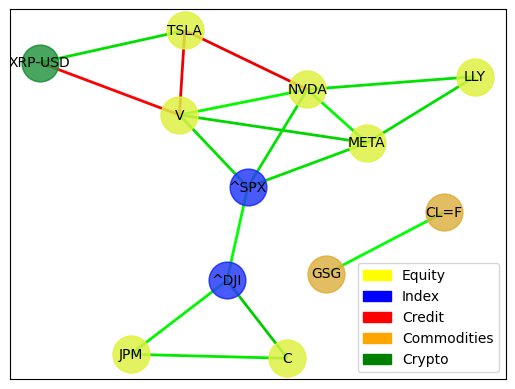

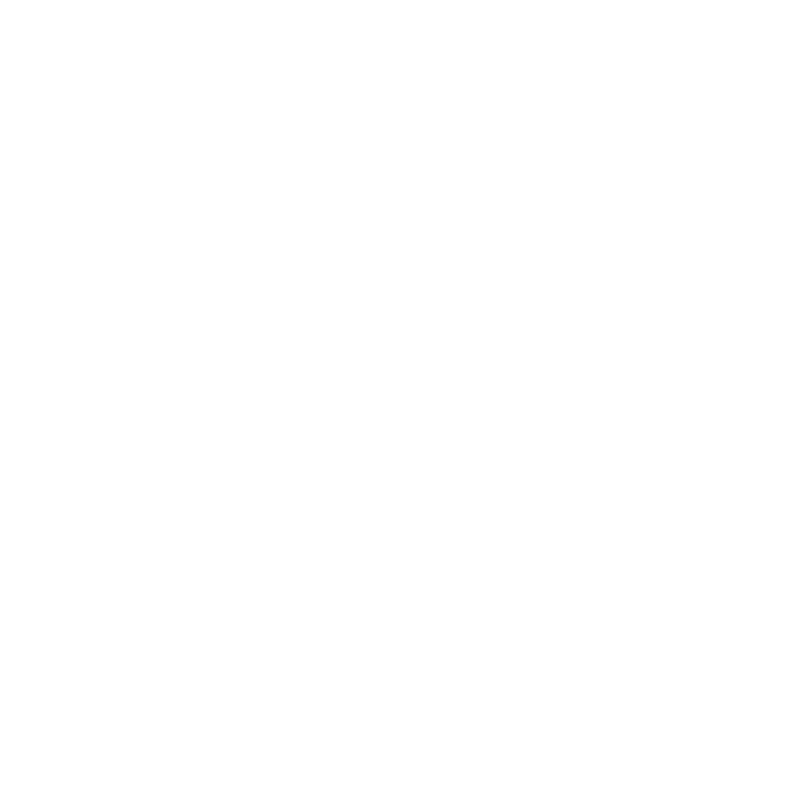

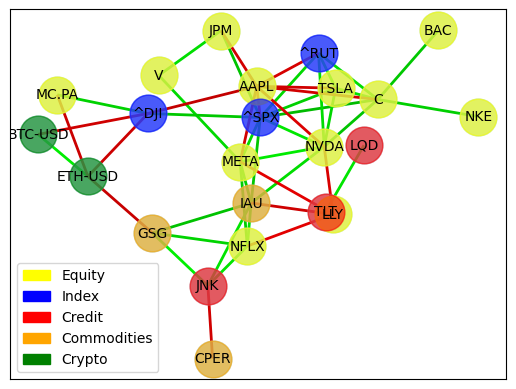

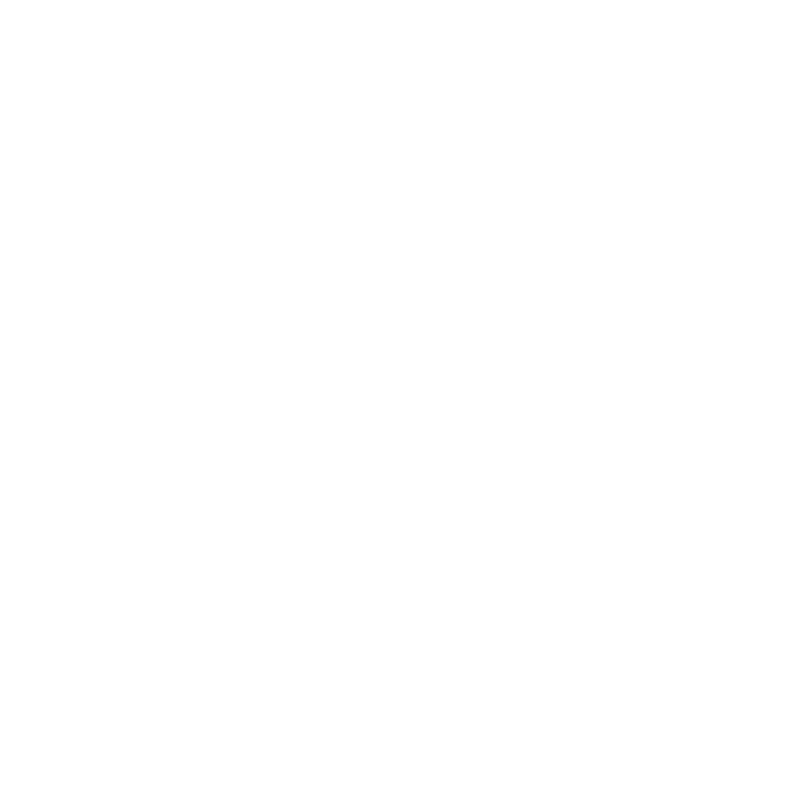

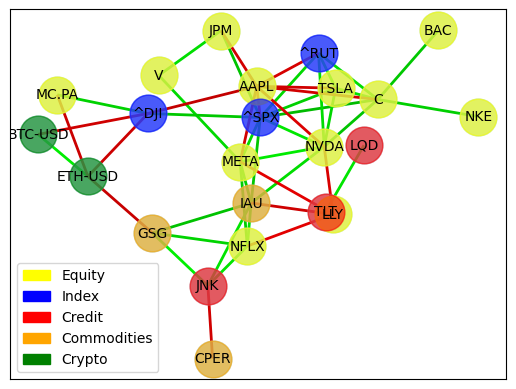

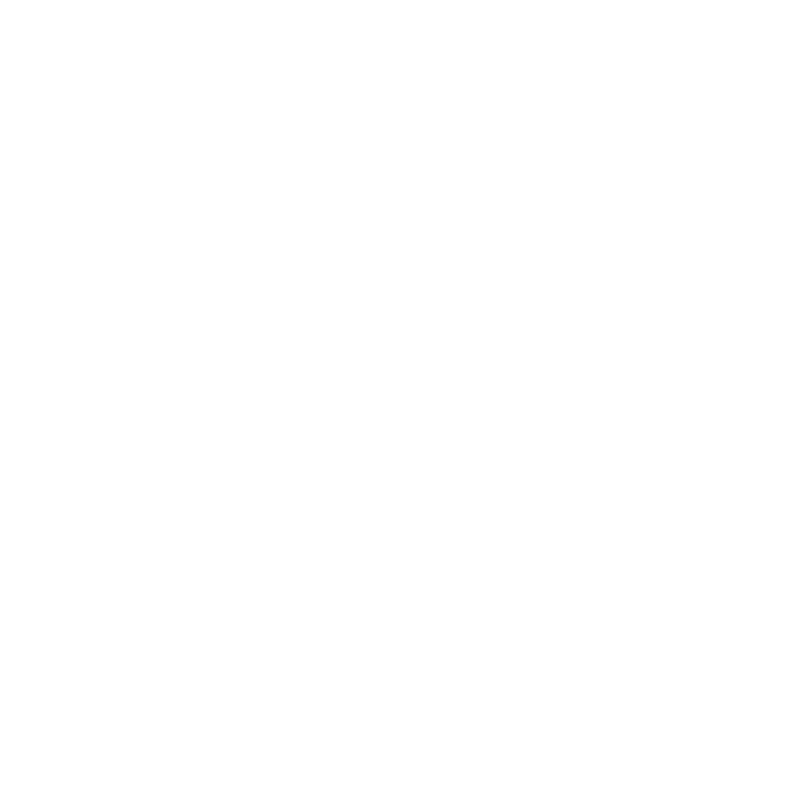

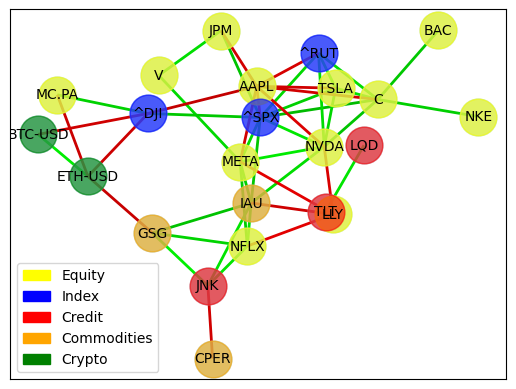

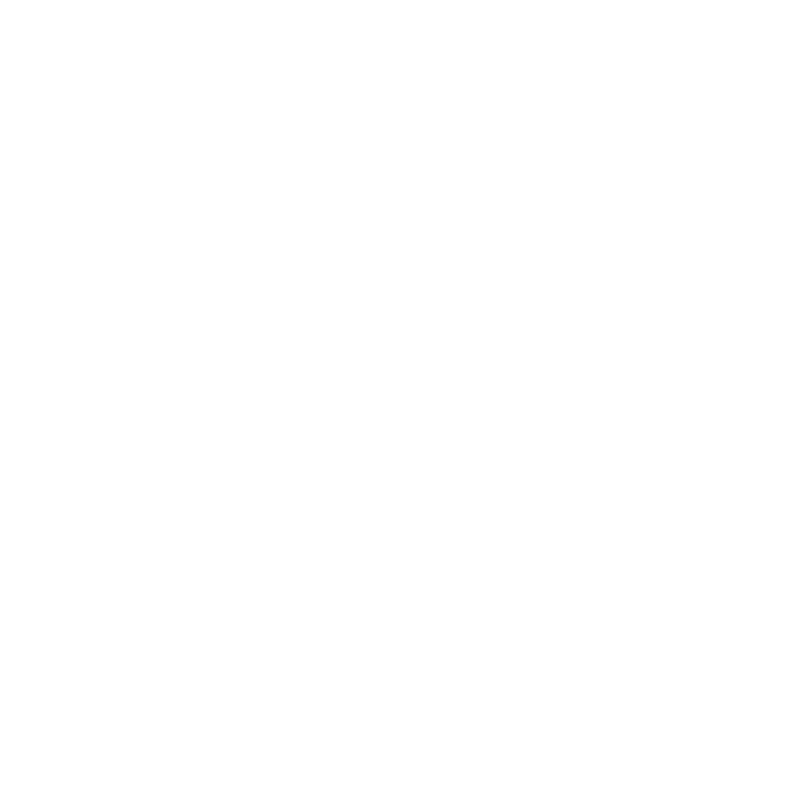

In [447]:
#KAMADA KAWAI LAYOUT


def graph_net(df, ref_date, corr_threshold, span=50):
    corr_matrix = rolling_corr(main_df, ref_date, span)
    # Create a graph from the correlation matrix
    G = nx.Graph()

    #Ticker Categs & Coloring:
    ticker_categs = {
        'Equity': ['AAPL', 'META', 'V', 'MC.PA', 'NFLX', 'NKE', 'JPM', 'BAC', 'C', 'NVDA', 'LLY', 'TSLA'],
        'Index': ['^SPX', '^DJI', '^RUT'],
        'Credit': ['TLT', 'JNK', 'LQD'],
        'Commodities': ['IAU', 'CPER', 'GSG', 'CL=F'],
        'Crypto': ['BTC-USD', 'ETH-USD', 'XRP-USD']               
    }

    colors = {
        'Equity' : 'yellow',
        'Index' : 'blue',
        'Credit' : 'red',
        'Commodities': 'orange',
        'Crypto': 'green'
    }


    # Add edges to the graph
    for col1 in corr_matrix.columns:
        for col2 in corr_matrix.index:
            corr = corr_matrix.loc[col1, col2]
            # Add edge if absolute correlation is above the threshold and avoid duplicate edges
            if abs(corr) > x and col1 != col2:
                # Check if the edge already exists (undirected graph, so A->B is the same as B->A)
                if not G.has_edge(col1, col2) and not G.has_edge(col2, col1):
                    G.add_edge(col1, col2, weight=corr)

    # Assuming 'G' is your original graph with 'weight' attributes holding the correlations
    H = G.copy()

    # Update edge weights in H to be absolute values of the original weights
    for u, v, d in H.edges(data=True):
        d['weight'] = abs(d['weight'])


    # Assuming H is your graph for layout and G contains original correlation weights
    pos = nx.kamada_kawai_layout(H)
    # pos = nx.shell_layout(H)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='skyblue', alpha=0.6)

    # Separate positive and negative correlations
    positive_edges = [(u, v, d) for u, v, d in G.edges(data=True) if d['weight'] > 0]
    negative_edges = [(u, v, d) for u, v, d in G.edges(data=True) if d['weight'] < 0]

    # Define normalization based on the range of correlation values
    # This normalization will be used to map correlation values to colors
    max_positive_corr = max(abs(d['weight']) for u, v, d in positive_edges) if positive_edges else 0
    max_negative_corr = max(abs(d['weight']) for u, v, d in negative_edges) if negative_edges else 0

    # Function to get color intensity based on correlation
    def get_color_intensity(corr_value, max_corr):
        return corr_value**3 / max_corr**3 if max_corr else 0.0  # Avoid division by zero


    # Draw nodes with colors based on categories, if the node is found in the ticker_categs dictionary
    for category, nodes in ticker_categs.items():
        valid_nodes = [node for node in nodes if node in G.nodes()]
        nx.draw_networkx_nodes(G, pos,
                               nodelist=valid_nodes,
                               node_size=700,
                               node_color=colors[category],
                               alpha=0.6)

    # Draw positive edges with varying shades of green
    for u, v, d in positive_edges:
        intensity = get_color_intensity(abs(d['weight']), max_positive_corr)
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=2,
                               edge_color=[(0, intensity, 0, 1)])  # RGBA tuple

    # Draw negative edges with varying shades of red
    for u, v, d in negative_edges:
        intensity = get_color_intensity(abs(d['weight']), max_negative_corr)
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=2,
                               edge_color=[(intensity, 0, 0, 1)])  # RGBA tuple


    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=10)

    # Create legend patches
    import matplotlib.patches as mpatches
    legend_patches = [mpatches.Patch(color=color, label=category) for category, color in colors.items()]
    plt.legend(handles=legend_patches)

    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.show()

graph_net(main_df, ref_date, 0.9)

### HEAT MAP 1 - Relative change of Rolling Correlations between Assets Log Returns

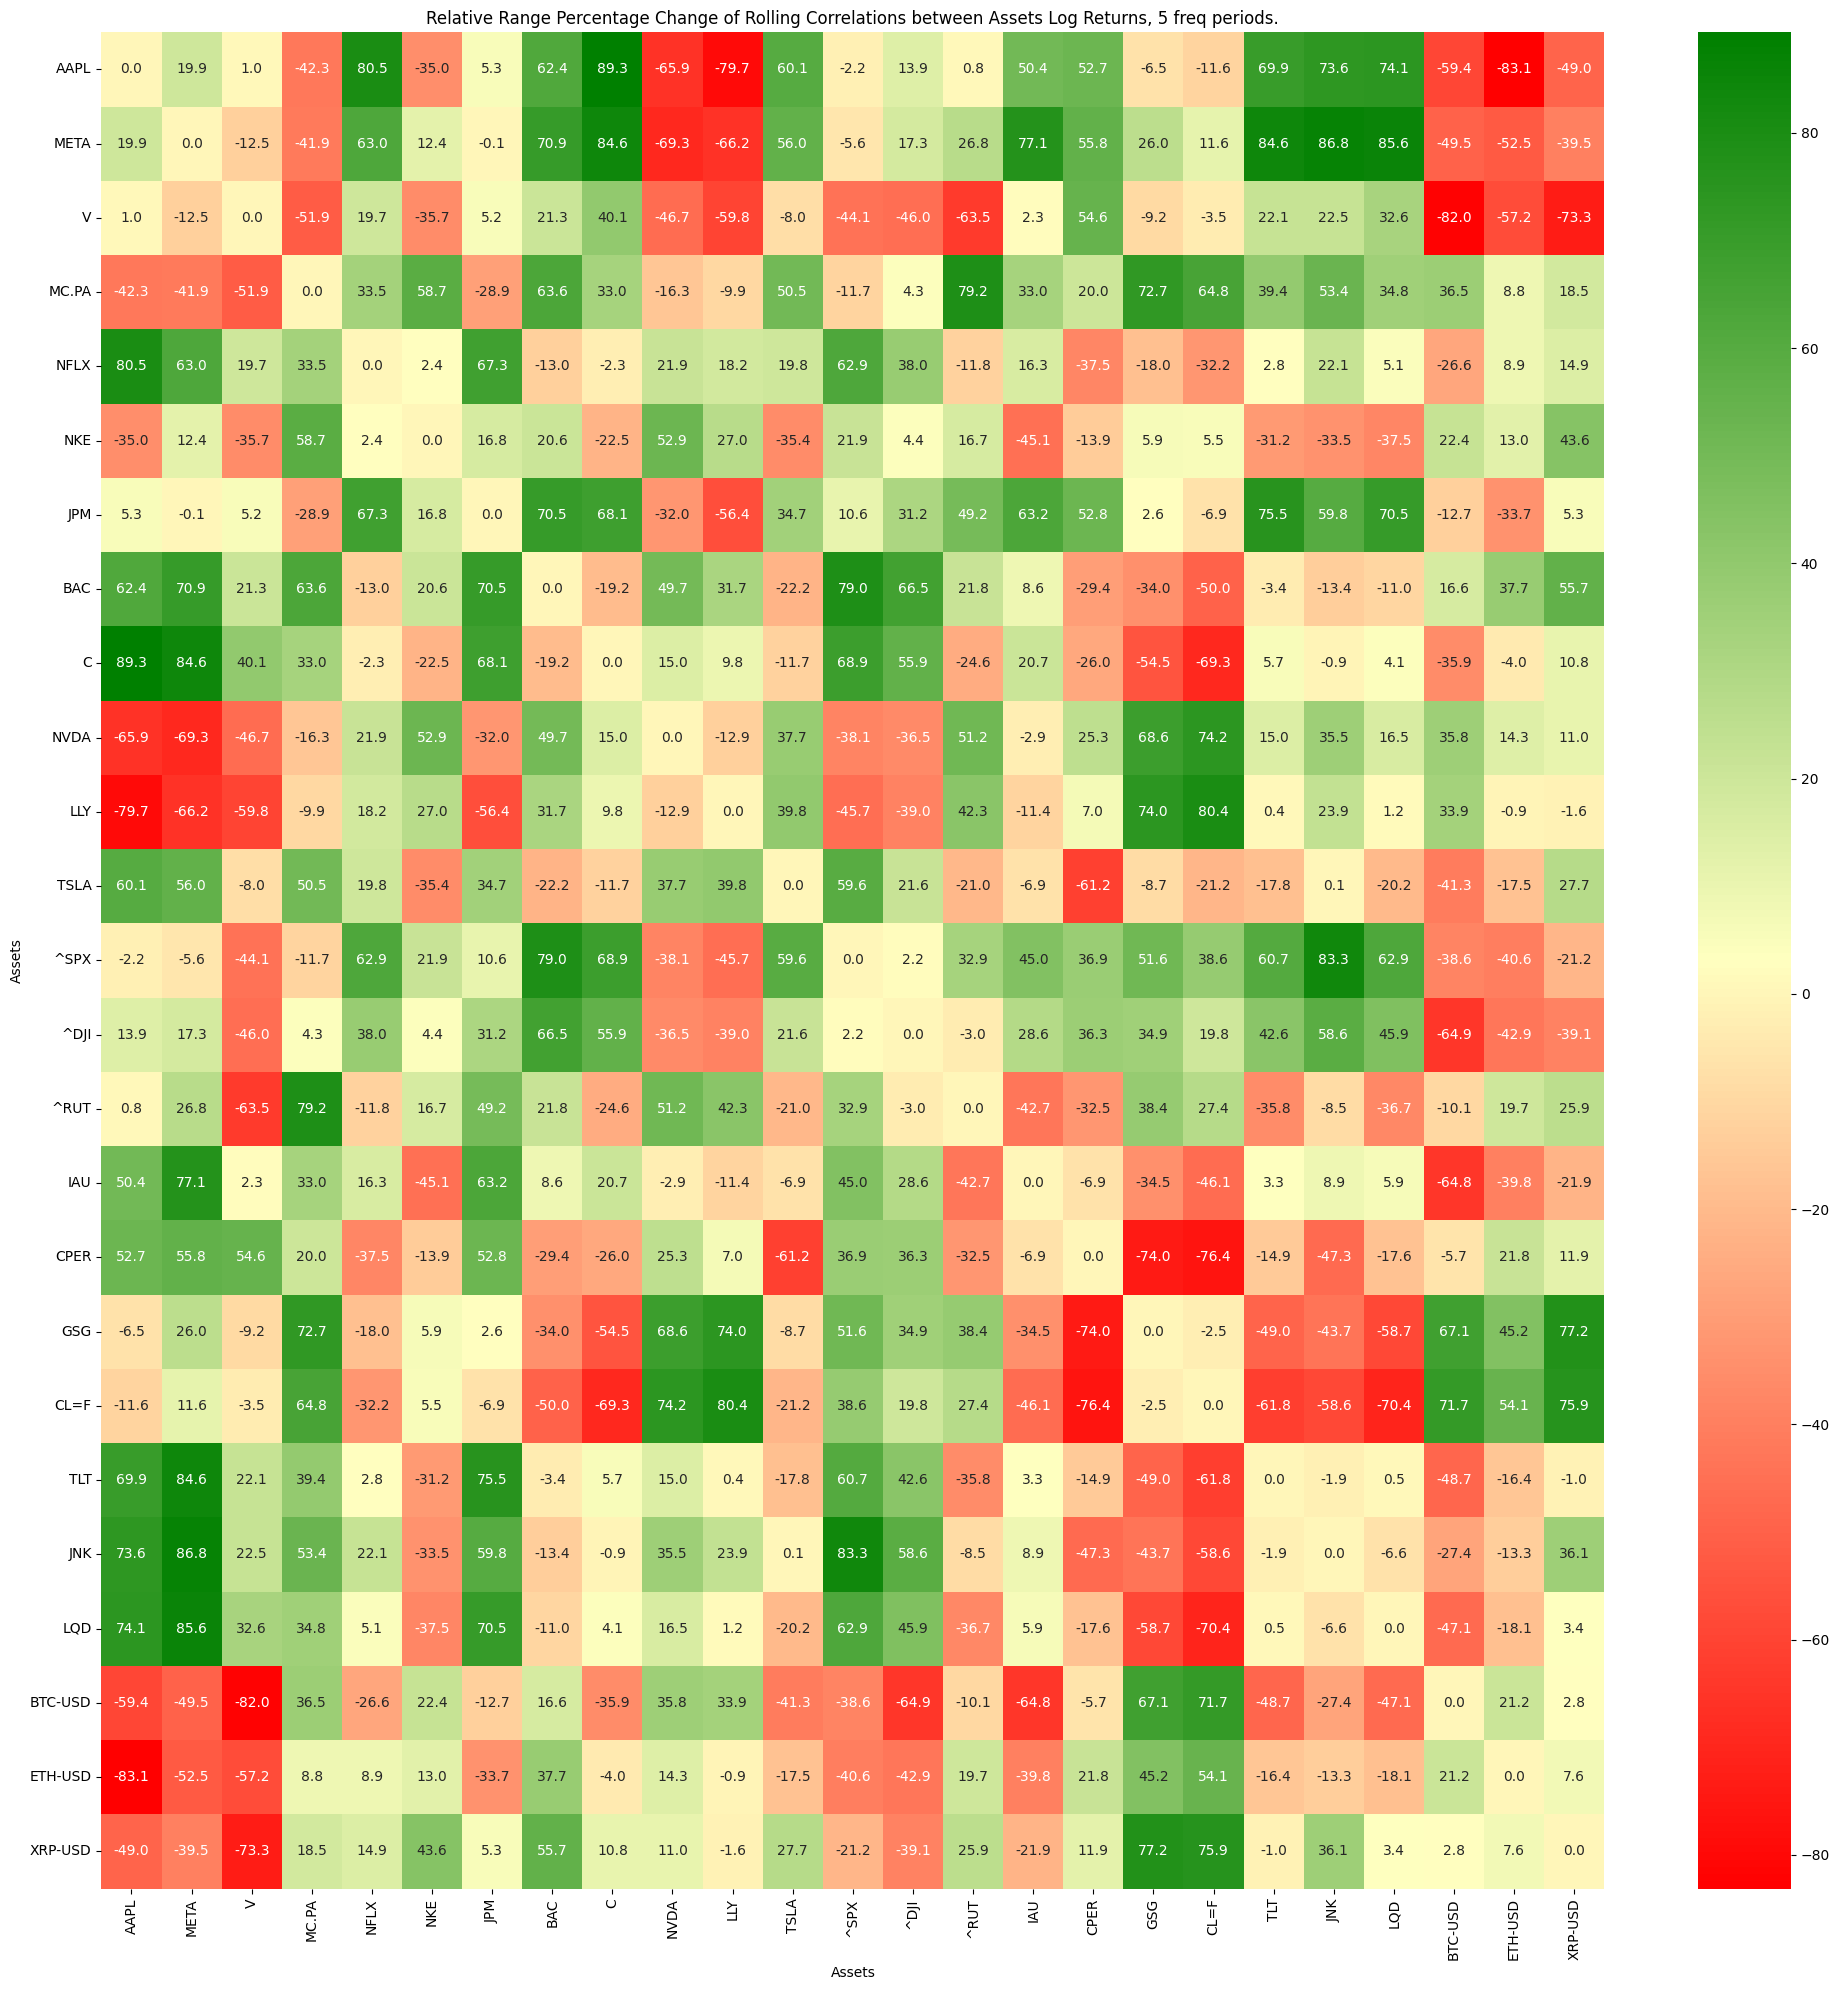

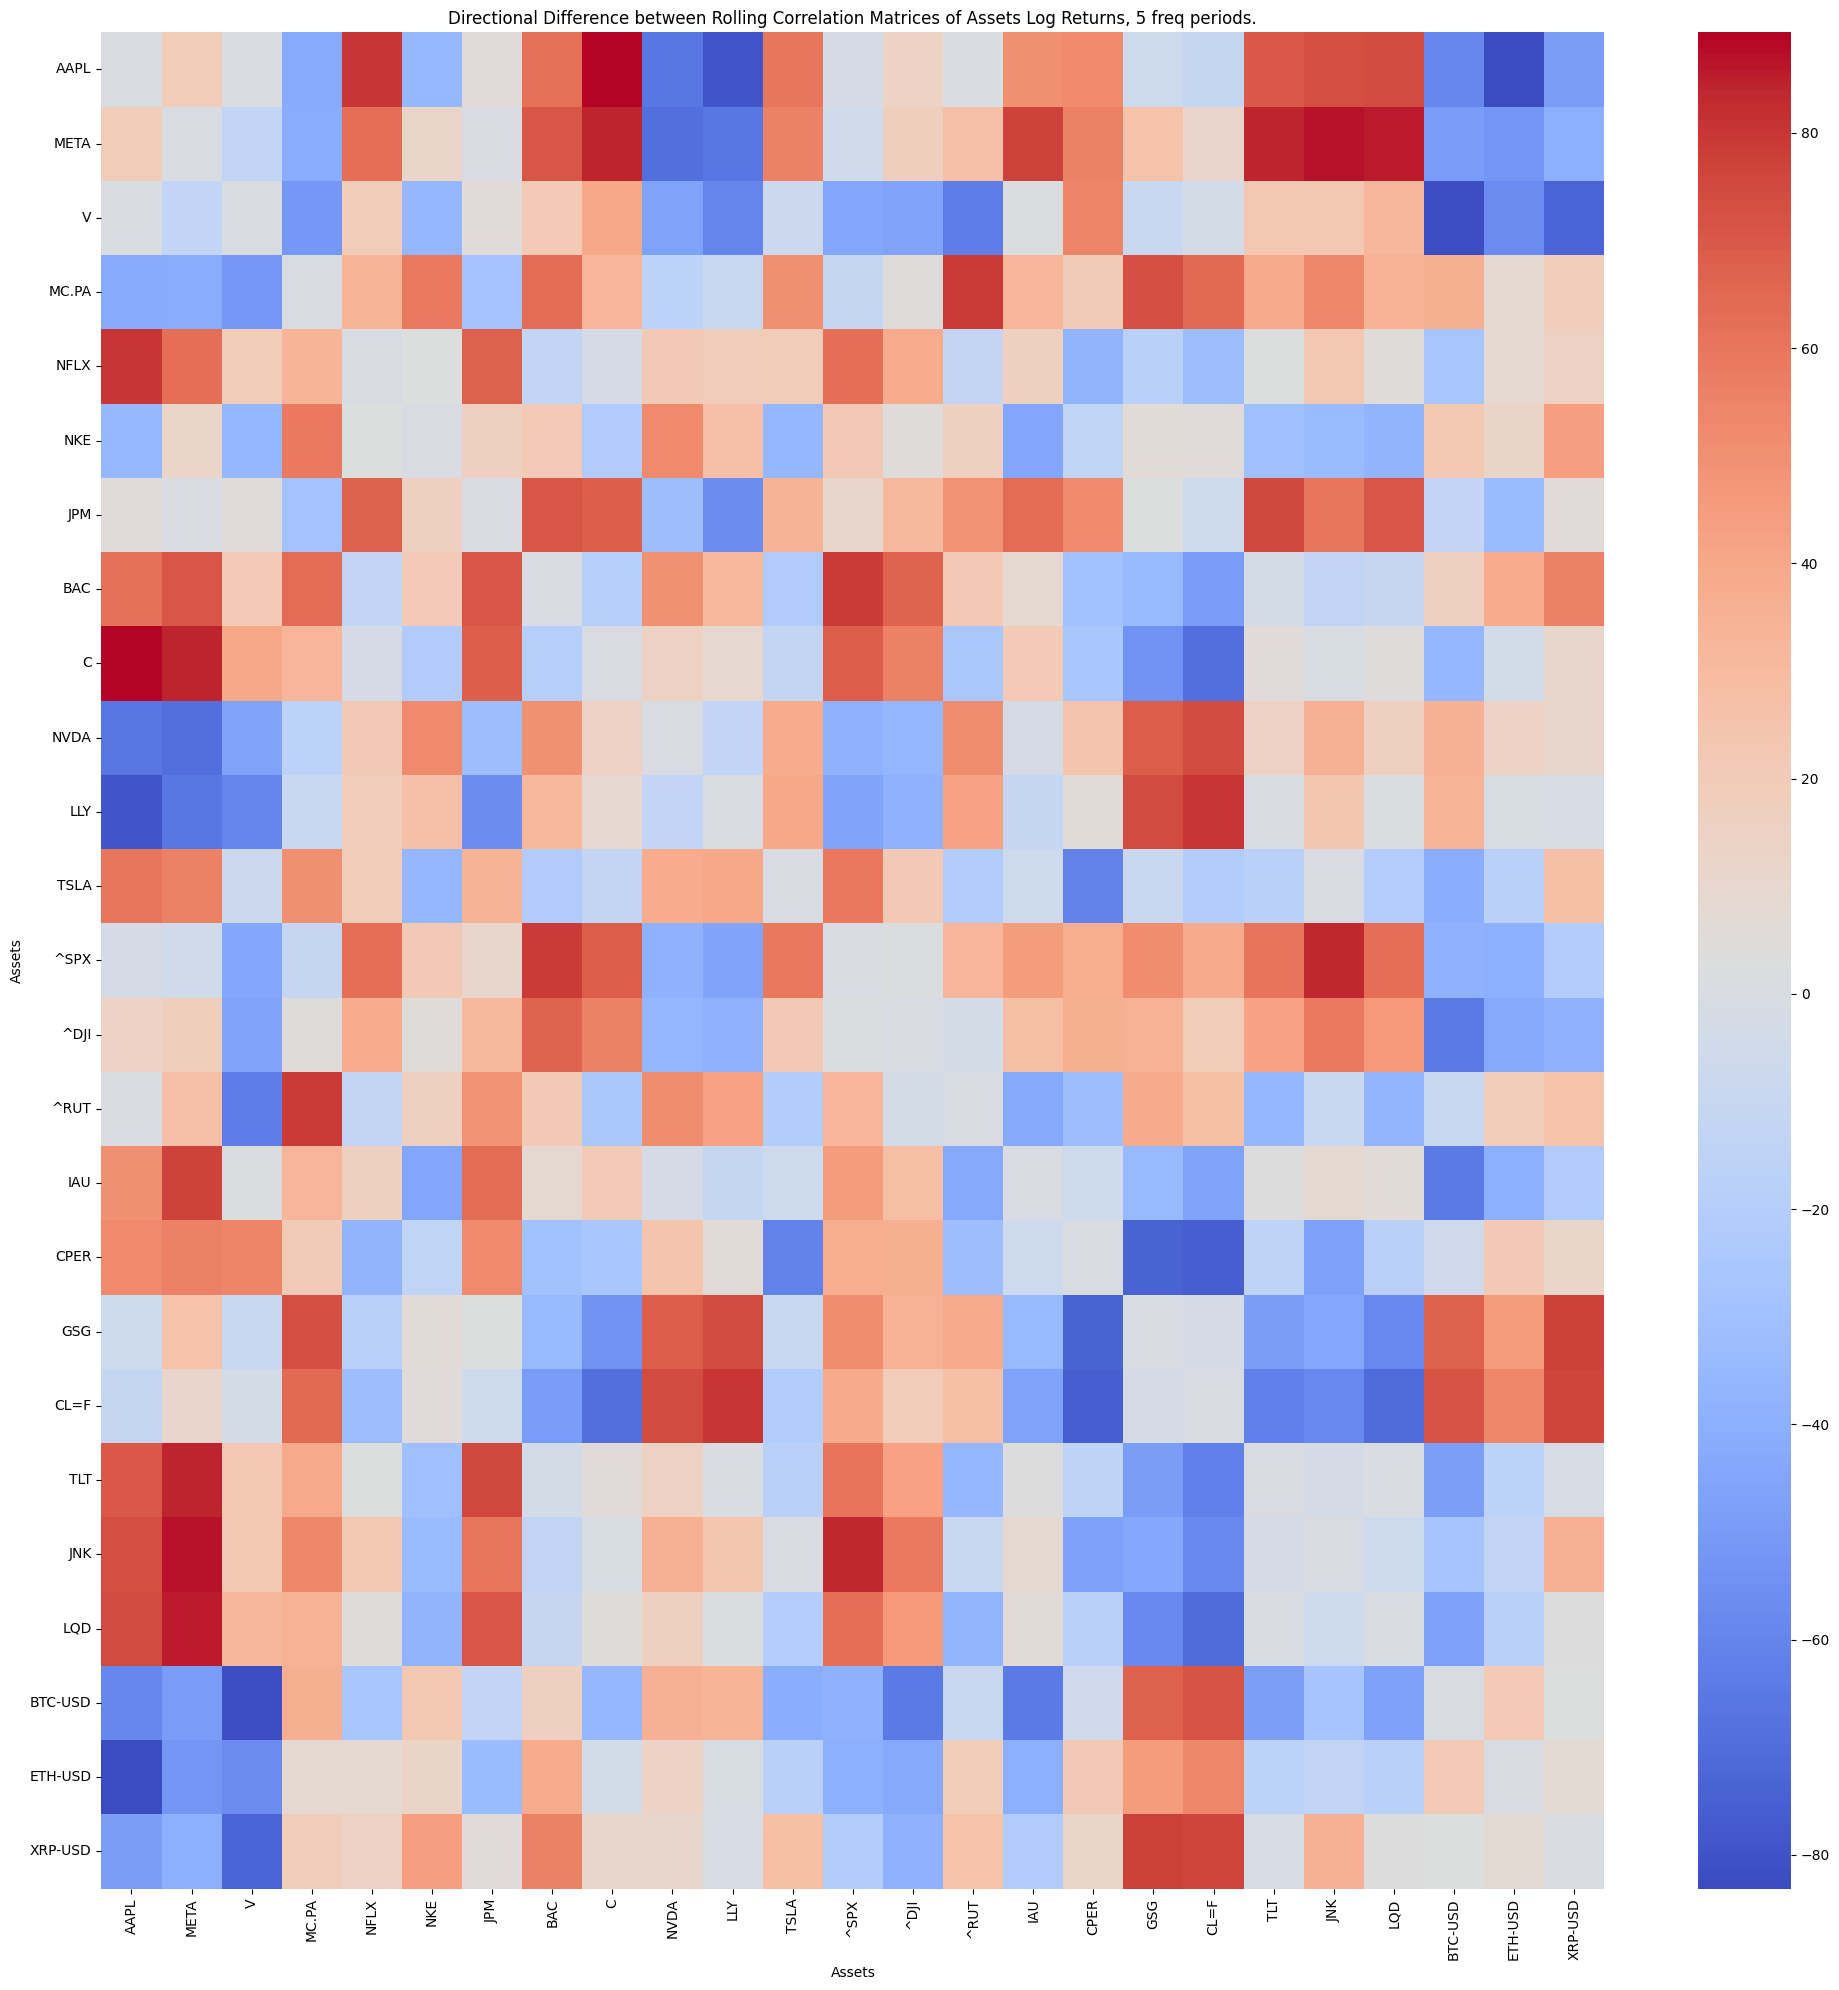

,AAPL,META,V,MC.PA,NFLX,NKE,JPM,BAC,C,NVDA,...,IAU,CPER,GSG,CL=F,TLT,JNK,LQD,BTC-USD,ETH-USD,XRP-USD
0,0.000000,19.851510,1.035067,-42.300884,80.472091,-34.982390,5.311413,62.355104,89.338402,-65.880822,...,50.360330,52.706557,-6.490101,-11.586514,69.871272,73.591721,74.128271,-59.359227,-83.139958,-49.022062
1,19.851510,0.000000,-12.494731,-41.897981,62.990733,12.406732,-0.107972,70.912630,84.571201,-69.328315,...,77.110149,55.808291,25.991162,11.649808,84.582874,86.847734,85.643583,-49.497642,-52.515114,-39.539649
2,1.035067,-12.494731,0.000000,-51.858771,19.671070,-35.749195,5.166870,21.267188,40.137170,-46.725791,...,2.306279,54.593894,-9.184003,-3.490881,22.080386,22.484388,32.568862,-82.042089,-57.239151,-73.313764
3,-42.300884,-41.897981,-51.858771,0.000000,33.543677,58.742017,-28.860927,63.569496,32.978414,-16.267347,...,32.998162,19.989079,72.748029,64.834672,39.387694,53.428846,34.846928,36.501634,8.778068,18.474610
4,80.472091,62.990733,19.671070,33.543677,0.000000,2.442824,67.256553,-13.014546,-2.318394,21.850683,...,16.272522,-37.493996,-17.986207,-32.192866,2.829765,22.147926,5.083329,-26.613164,8.938687,14.904655
5,-34.982390,12.406732,-35.749195,58.742017,2.442824,0.000000,16.781047,20.620915,-22.472853,52.872027,...,-45.109342,-13.881069,5.912398,5.487042,-31.219125,-33.484309,-37.507086,22.375813,12.951131,43.568028
6,5.311413,-0.107972,5.166870,-28.860927,67.256553,16.781047,0.000000,70.481830,68.118532,-32.032347,...,63.212246,52.796272,2.570838,-6.947837,75.512114,59.790331,70.546415,-12.724933,-33.692033,5.281237
7,62.355104,70.912630,21.267188,63.569496,-13.014546,20.620915,70.481830,0.000000,-19.240140,49.701447,...,8.603806,-29.421125,-33.988569,-50.045588,-3.372560,-13.350909,-10.999681,16.596028,37.667289,55.687338
8,89.338402,84.571201,40.137170,32.978414,-2.318394,-22.472853,68.118532,-19.240140,0.000000,14.993612,...,20.671339,-26.038171,-54.493706,-69.268961,5.737522,-0.902181,4.113060,-35.910915,-3.954024,10.800500
9,-65.880822,-69.328315,-46.725791,-16.267347,21.850683,52.872027,-32.032347,49.701447,14.993612,0.000000,...,-2.861674,25.274922,68.628513,74.218076,15.026465,35.462666,16.518340,35.790917,14.279425,10.994418


In [410]:
# Testing
corr_diff = rolling_corr_difference(main_df, test_date, span=span)[0]
corr_diff


### HEATMAP 2 - CATEGORIZATION OF DIFFERENCE IN LOG RETURNS CORRELATION THROUGH TIME PERIOD

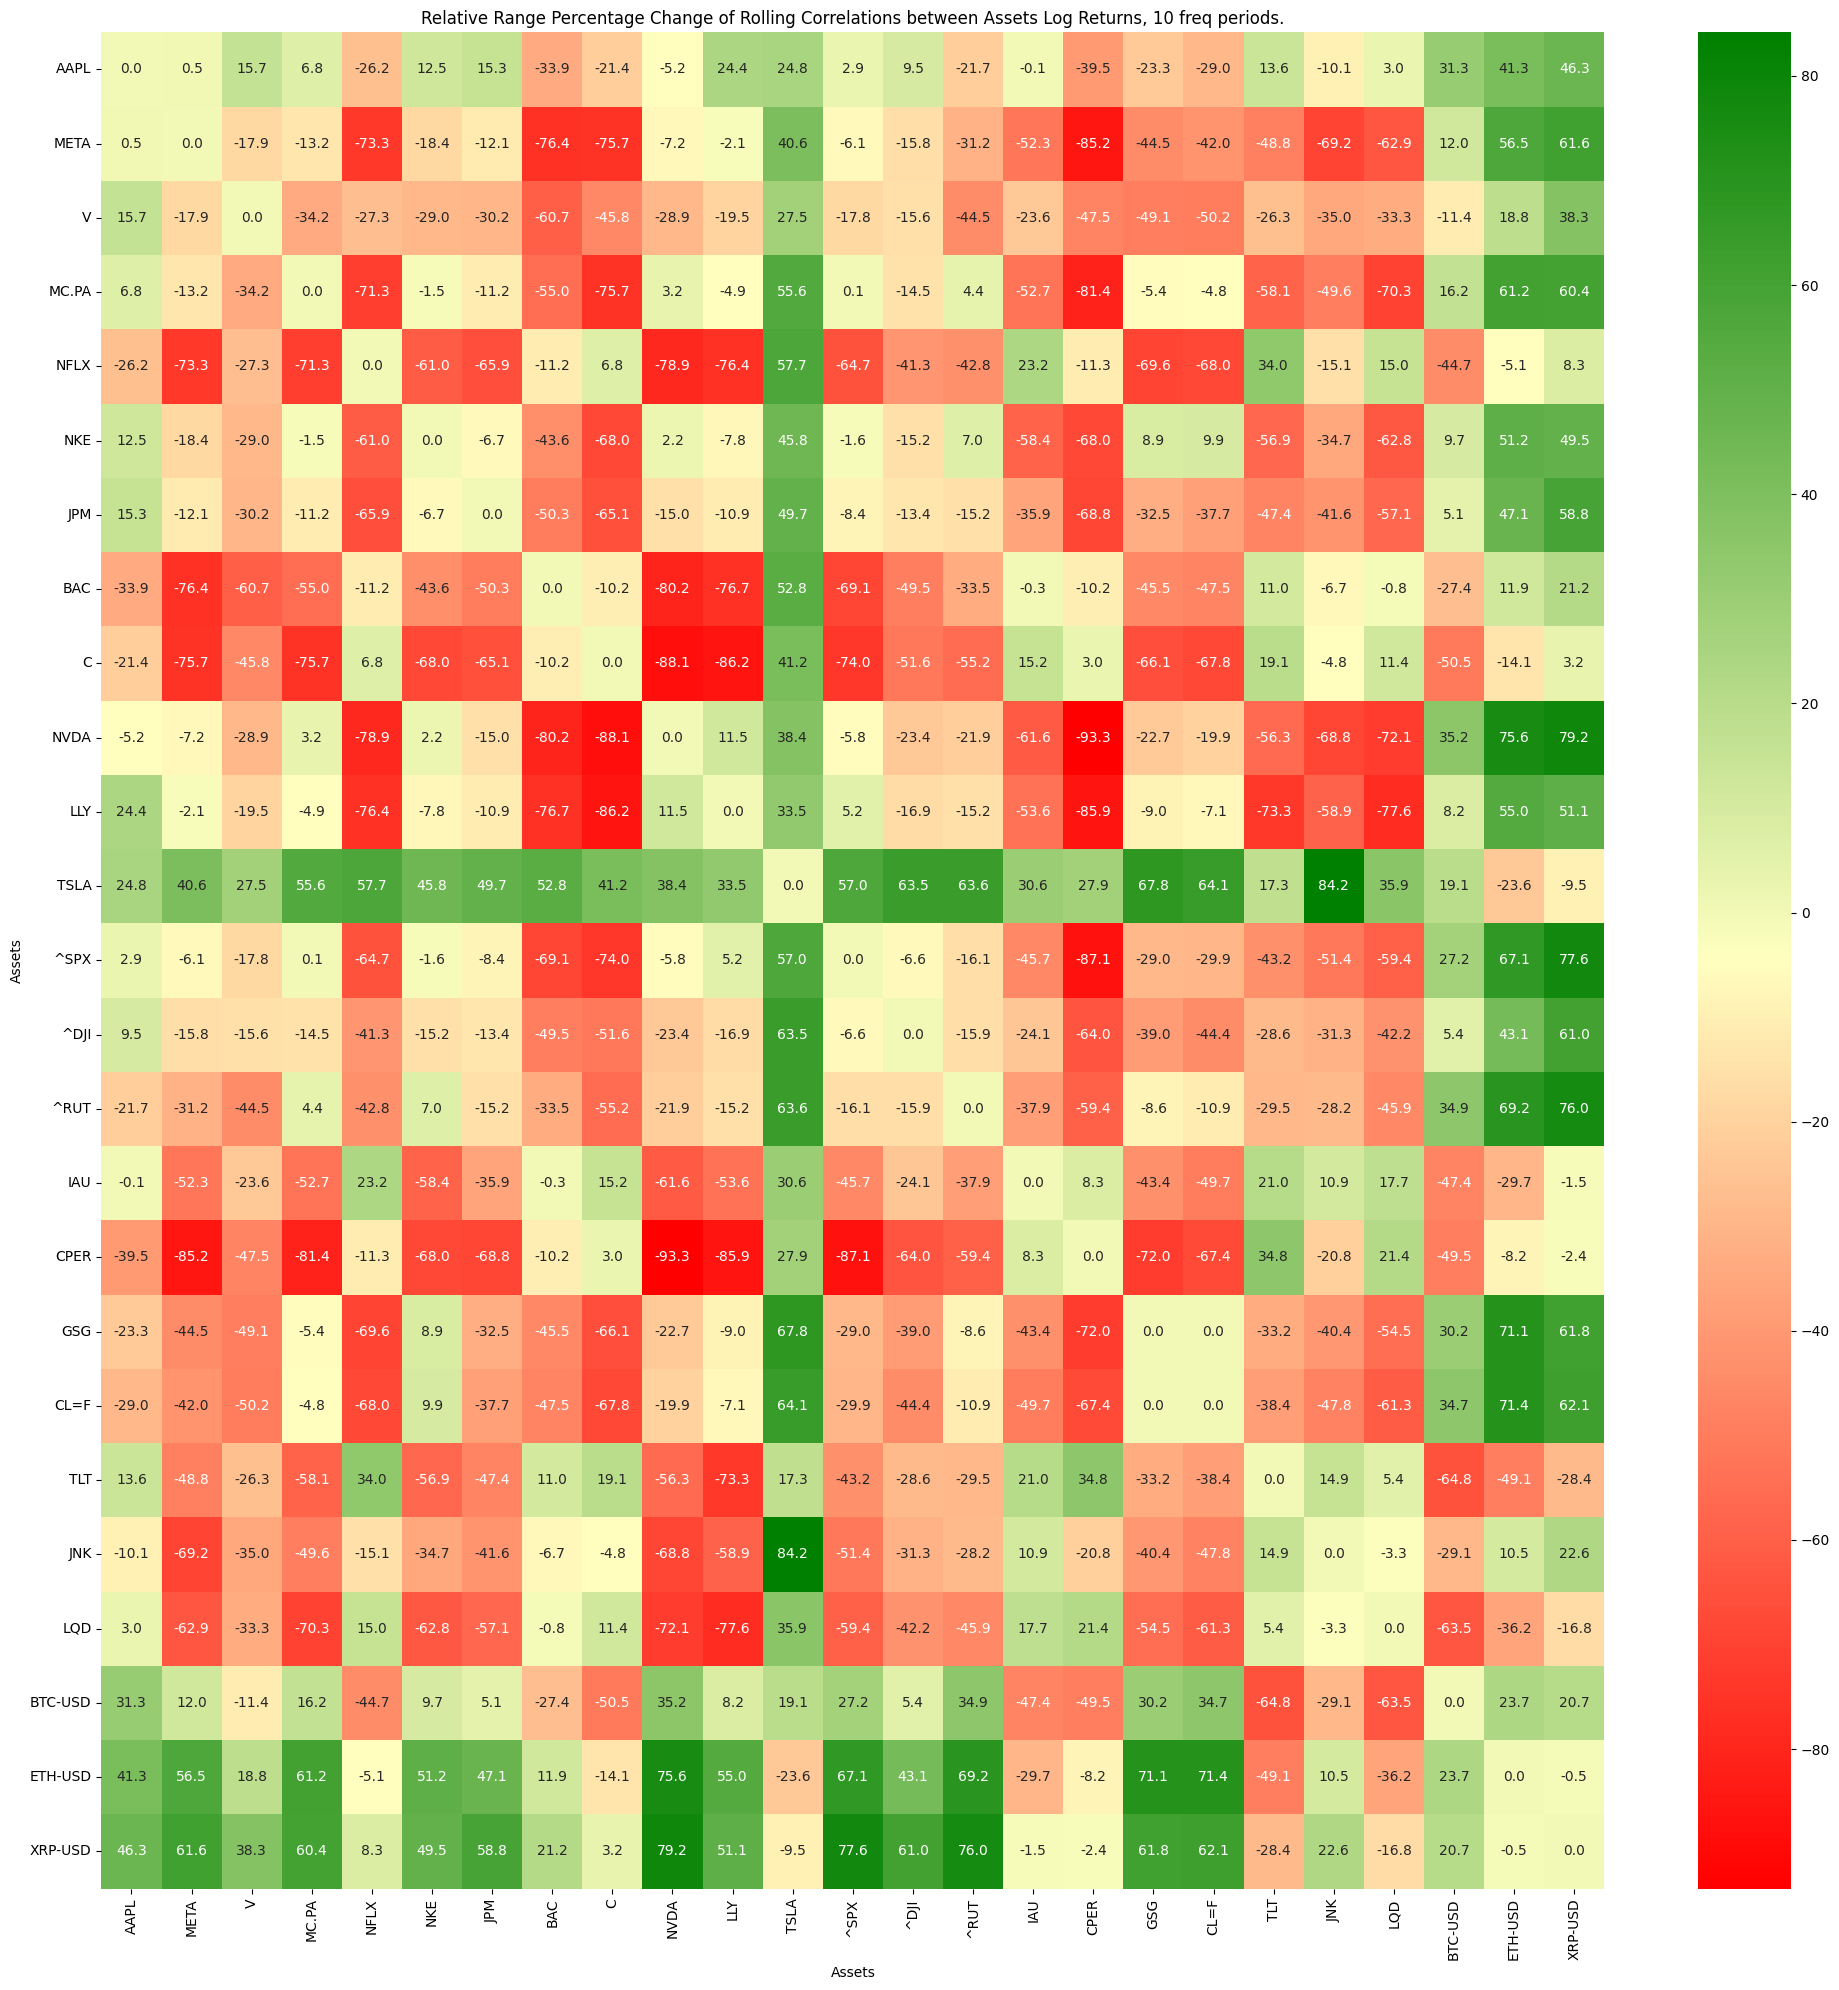

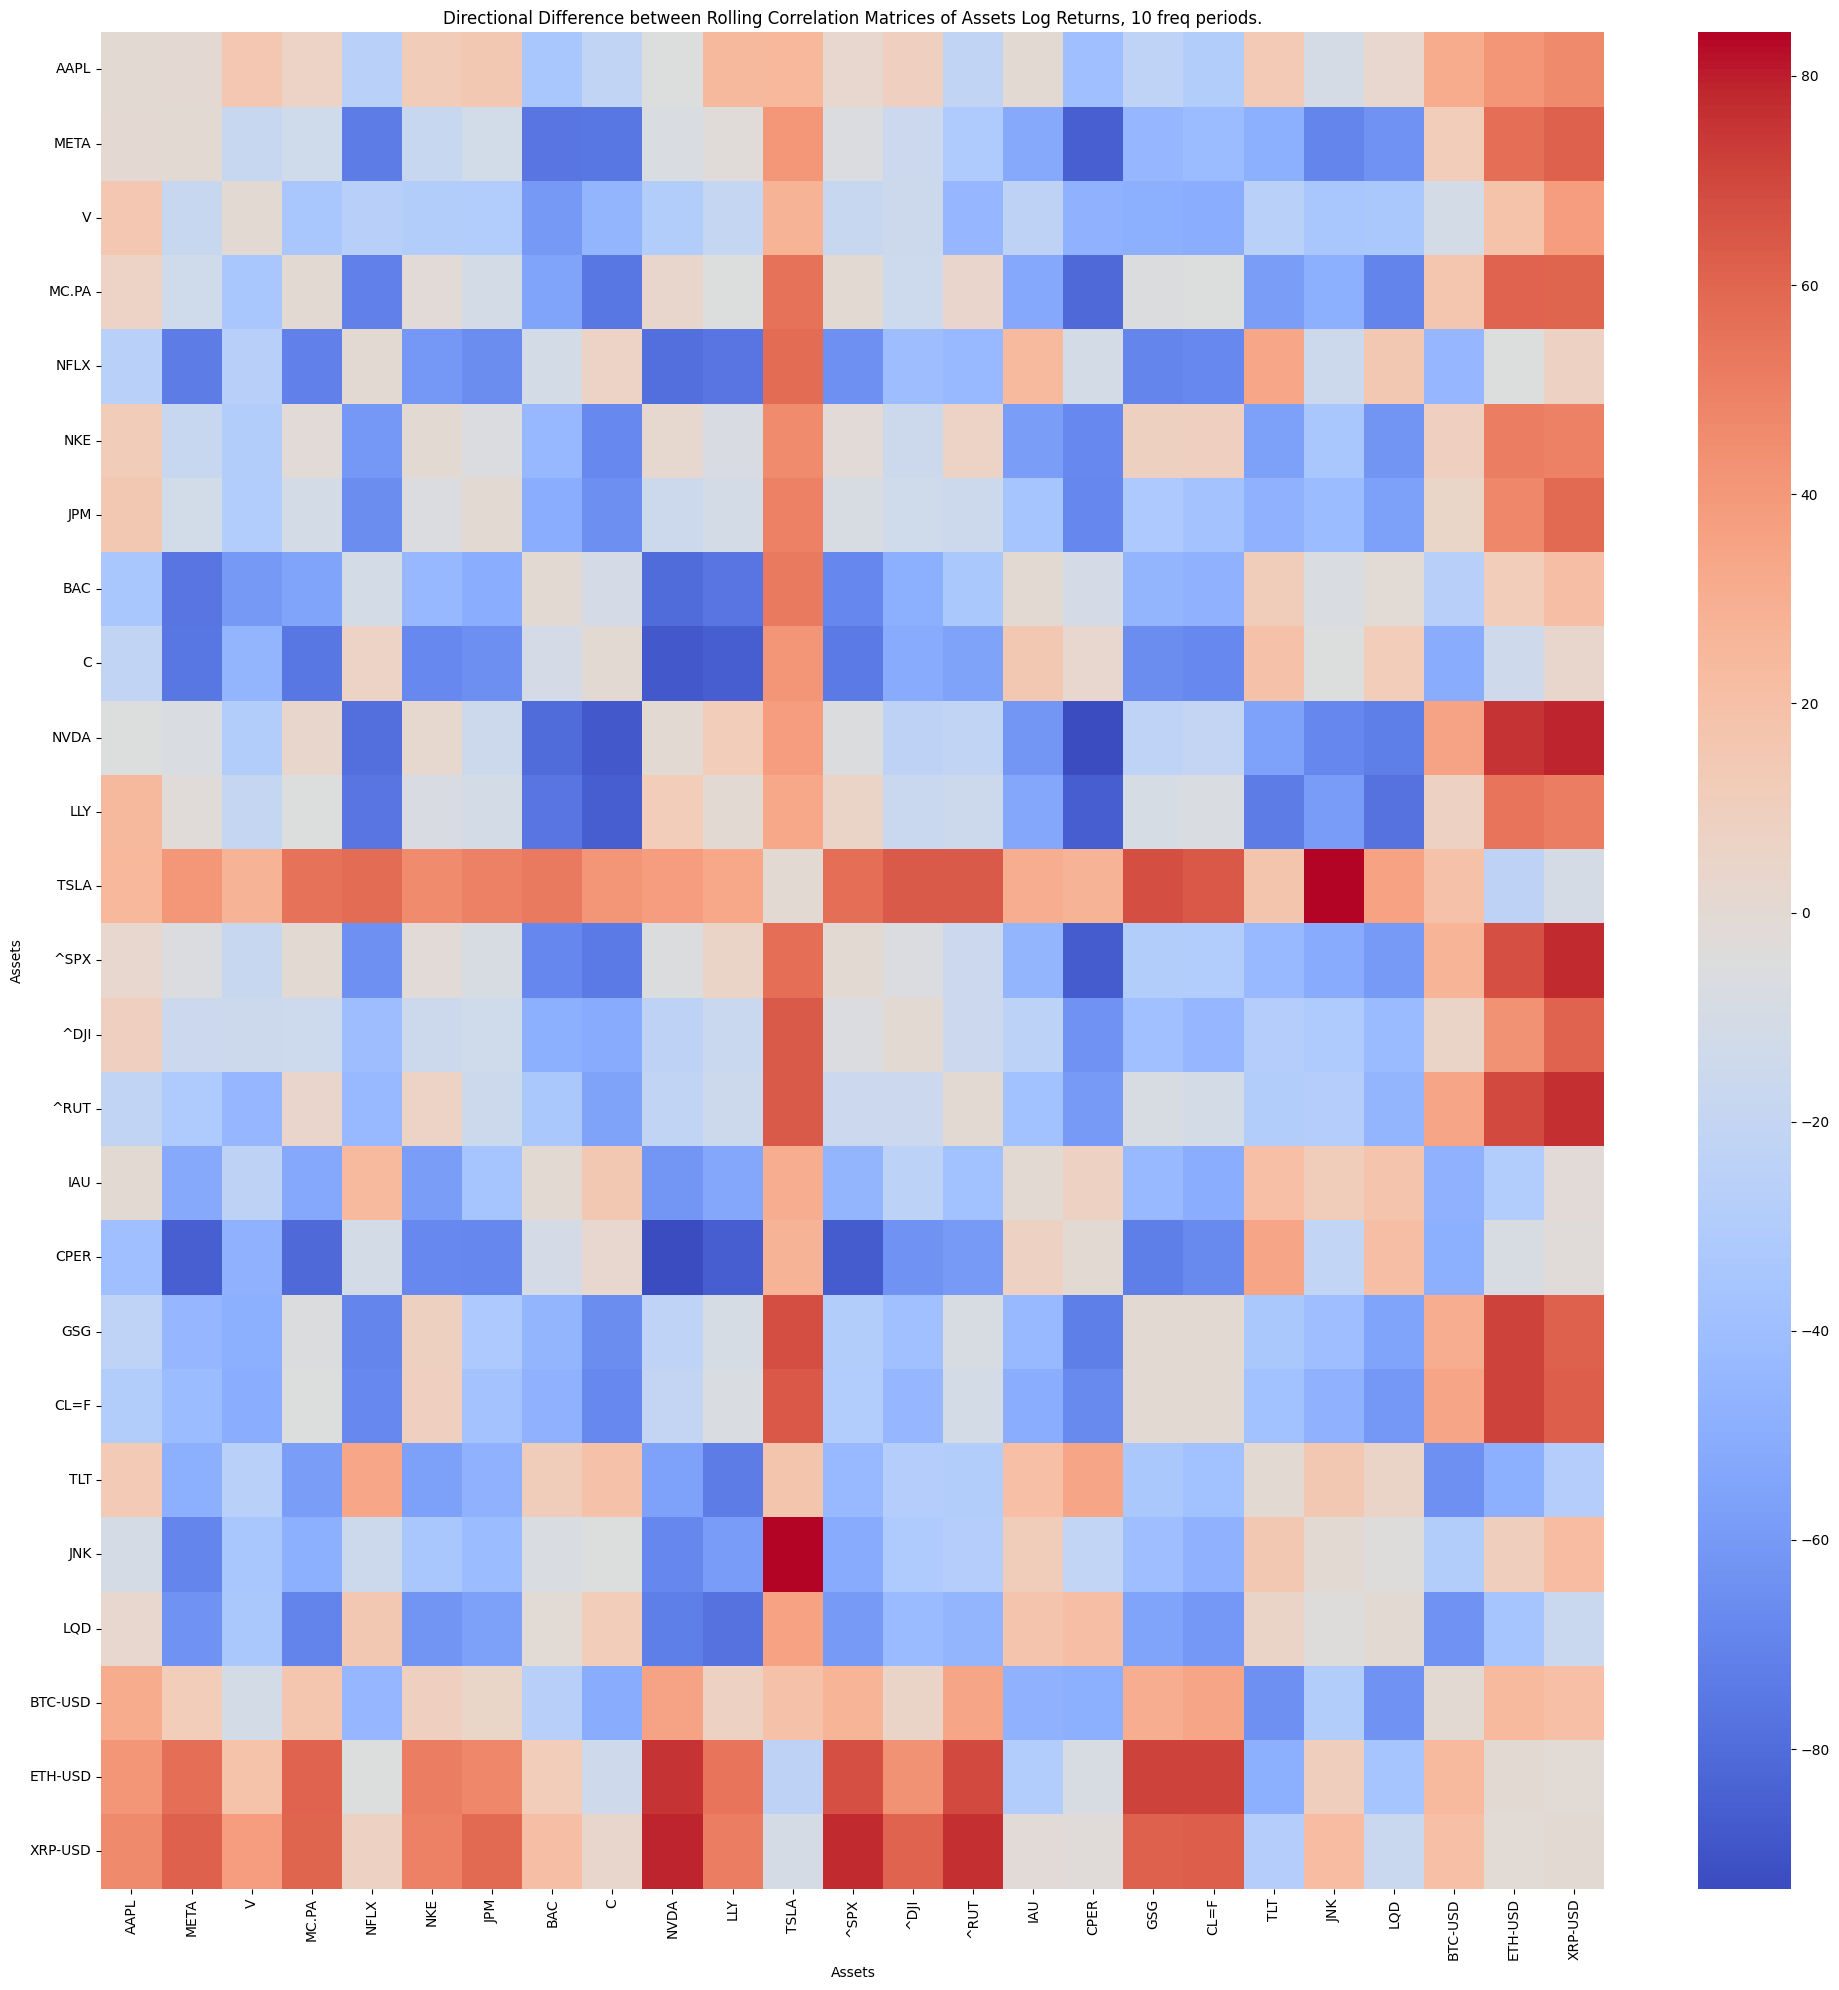

,AAPL,META,V,MC.PA,NFLX,NKE,JPM,BAC,C,NVDA,...,IAU,CPER,GSG,CL=F,TLT,JNK,LQD,BTC-USD,ETH-USD,XRP-USD
0,5,10,10,10,-10,10,10,-10,-10,5,...,5,-10,-10,-10,-10,5,-10,-10,10,10
1,10,5,5,5,-10,5,5,-10,-10,5,...,-10,-10,5,5,-10,-10,-10,10,10,10
2,10,5,5,-10,-10,-10,5,-10,-10,5,...,5,-10,-10,-10,5,-10,5,-10,-10,10
3,10,5,-10,5,-10,5,5,-10,-10,10,...,-10,-10,5,5,-10,-10,-10,10,10,10
4,-10,-10,-10,-10,5,-10,-10,5,10,-10,...,10,5,-10,-10,10,5,10,-10,-5,-10
5,10,5,-10,5,-10,5,5,-10,-10,10,...,-10,-10,10,10,-10,-10,-10,10,10,10
6,10,5,5,5,-10,5,5,-10,-10,5,...,-10,-10,5,5,-10,5,-10,10,10,10
7,-10,-10,-10,-10,5,-10,-10,5,5,-10,...,5,5,-10,-10,10,5,5,-10,-10,-10
8,-10,-10,-10,-10,10,-10,-10,5,5,-10,...,10,10,-10,-10,10,5,10,-10,-5,-10
9,5,5,5,10,-10,10,5,-10,-10,5,...,-10,-10,5,5,-10,-10,-10,10,10,10


In [445]:
# Testing
corr_diff = rolling_corr_difference(main_df, test_date, span=10)[1]
corr_diff